This one has been on the back burner for quite a while. When Pat Lorton was working on the initial version of [gpusimilarity](https://github.com/schrodinger/gpusimilarity) and his presentation for the [2018 RDKit UGM](https://github.com/schrodinger/gpusimilarity/blob/master/gpusimilarity_rdkit_presentation.pdf) he dealt with the limited amount of memory available on GPUs by loading highly folded fingerprints into the GPU, retrieving extra compounds for a TopN query, and then rescoring those compounds using full-sized fingerprints. I wanted to go back and look at the same problem again from the perspective of a threshold similarity query - i.e. "give me all of the results that have a similarity above my threshold" - instead of the TopN query - i.e. "give me the N nearest neighbors in the database" - Pat was looking at.

This blog post starts that. I'm not going to take a more general approach and look at the impact of fingerprint size on search results and performance at various threshold levels. I'm not going to actually use gpusimilarity in this particular post, but hopefully I will get to that in the future.

This post ended up being longer than I thought it was going to be... here's an overview of the pieces:

- Look at the impact of folding on computed similarity values.  [link](#Impact-of-fingerprint-size-on-computed-similarity)
- Look at the impact of folding on the number of results returned by a similarity search. [link](#Comparing-the-the-number-of-neighbors-retrieved)
- How many hits do we miss by folding the fingerprints? [link](#How-many-hits-do-we-miss?)
- How many extra hits do we retrieve when folding the fingerprints? [link](#Efficiency,-look-at-the-number-of-extra-hits)
- Performance: what impact does fingerprint size have on search times in PostgreSQL? [link](#In-PostgreSQL)
- Performance: what impact does fingerprint size have on search times using [FPSim2](https://github.com/chembl/FPSim2)? [link](#Using-FPSim2)

The TL;DR summary: When working with the RDKit's Morgan2 fingerprint (MFP2), I think it's reasonable to fold the fingerprints down to 128 bits, particularly when using higher similarity thresholds. This balances the number of hits missed against the number of extra hits retrieved and can result in significant performance improvements when using a specialized search tool like [FPSim2](https://github.com/chembl/FPSim2). The smaller fingerprints - 128 bit fingerprints are 1/16th the size of 2048 bit fingerprints - are faster to read from storage and allow us to fit considerably more fingerprints in the same amount of memory, which is particularly helpful with GPUs.

In [10]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import RDLogger
from rdkit import rdBase
from rdkit import DataStructs
import pickle
import time
import gzip
print(rdBase.rdkitVersion)
print(time.asctime())
%pylab inline

2020.03.5
Mon Aug 24 05:12:00 2020
Populating the interactive namespace from numpy and matplotlib


# Impact of fingerprint size on computed similarity

Start by looking at the impact of increased fingerprint folding - decreasing fingerprint size - on similarity values.

For this I use the [similarity comparison set](https://rdkit.blogspot.com/2016/04/revisiting-similarity-comparison-set.html) that I put together a few years ago. I'm more interested in the impact on molecules that have a reasonable similiarty to each other, so I'm using the set of pairs that have tanimoto similarity of at least 0.6 with the Morgan1 fingerprint. 

Generate the similarity values for multiple bit counts:

In [60]:
rows=[]
for row in gzip.open('../data/chembl21_25K.mfp1.pairs.txt.gz').readlines():
    row = row.split()
    row[1] = Chem.MolFromSmiles(row[1])
    row[3] = Chem.MolFromSmiles(row[3])
    rows.append(row)

In [61]:
sims = defaultdict(list)
for i,row in enumerate(rows):
    m1 = row[1]
    m2 = row[3]
    fp1 = rdMolDescriptors.GetMorganFingerprint(m1,2)
    fp2 = rdMolDescriptors.GetMorganFingerprint(m2,2)
    sims[-1].append(DataStructs.TanimotoSimilarity(fp1,fp2))
    
    for bitsize in (64, 128, 256, 512,1024,2048,4096):
        fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(m1,2,nBits=bitsize)
        fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(m2,2,nBits=bitsize)
        sims[bitsize].append(DataStructs.TanimotoSimilarity(fp1,fp2))
    if not (i+1)%5000: print("Done:",i+1)

Done: 5000
Done: 10000
Done: 15000
Done: 20000
Done: 25000


And then plot histograms to show how much the similarity changes relatively to the 4096 bit fingerprint for the different bit counts. 

Positive values indicate that the folded fingerprint yields a higher similarity

I include the histogram twice: once with a linear y axis and once with a log y axis so that the behavior at the edges is more visible.

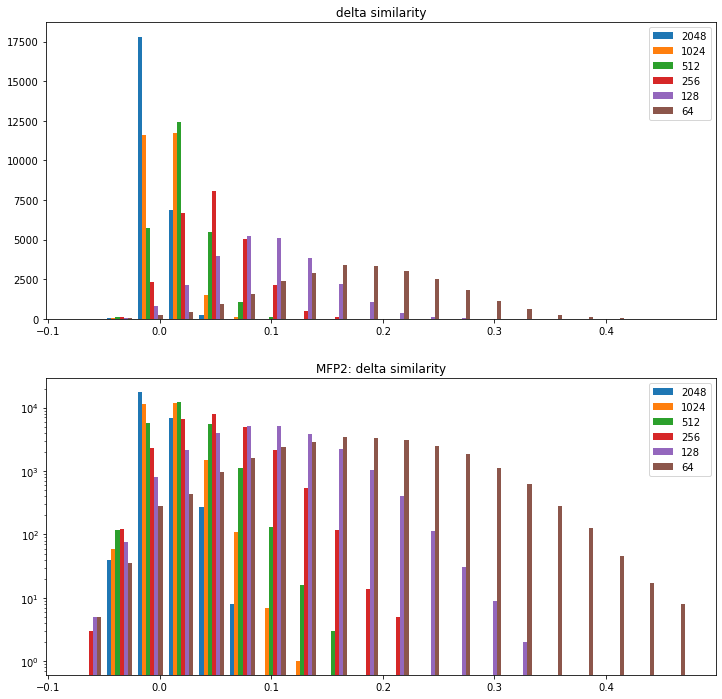

In [74]:
figsize(12,12)
bcounts = (2048,1024,512,256,128,64)

diffs = []
for bcount in bcounts:
    diffs.append(np.array(sims[bcount])-np.array(sims[4096]))
subplot(2,1,1)
hist(diffs,label=[str(x) for x in bcounts],bins=20);
legend();
title('delta similarity');
subplot(2,1,2)
hist(diffs,label=[str(x) for x in bcounts],bins=20,log=True);
legend();
title('MFP2: delta similarity');

Clear (and generally unsurprising) conclusion from this: folding the fingerprints tends to increase computed similarity values. Going all the way down to 64bits does so dramatically.

It's also worth looking at how much the folding changes the ranking of similarities. This is where I may get into trouble with people who are better at stats than I am, but I think the right metric for this is [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient):

In [81]:
from scipy import stats
bcounts = (2048,1024,512,256,128,64)
for bcount in bcounts:
    r,p = stats.spearmanr(sims[bcount],sims[4096])
    print(f"{bcount} bits: r={r:.3f} p={p:.3g}")

2048 bits: r=0.997 p=0
1024 bits: r=0.994 p=0
512 bits: r=0.985 p=0
256 bits: r=0.965 p=0
128 bits: r=0.919 p=0
64 bits: r=0.811 p=0


It's nice to see how high these are. Even the super-short 64 bit fingerprints maintain the ranking of these pairs reasonably well.

In [another blog post](https://rdkit.blogspot.com/2020/06/number-of-bits-set-compared-between.html) I showed that the Morgan2 fingerprint sets comparatively few bits compared to some of the other fingerprints available in the RDKit: compare ~50 bits per molecule with MFP2 with the ~1000 bits per molecule set by the RDKit fingerprint.

I assume that the higher bit densities of the RDKit fingerprint will cause similarity values to increase more rapidly as the fingerprint is folded. 

Let's test that assumption:

In [75]:
rdksims = defaultdict(list)
for i,row in enumerate(rows):
    m1 = row[1]
    m2 = row[3]
    for bitsize in (64, 128, 256, 512,1024,2048,4096):
        fp1 = Chem.RDKFingerprint(m1,fpSize=bitsize)
        fp2 = Chem.RDKFingerprint(m2,fpSize=bitsize)
        rdksims[bitsize].append(DataStructs.TanimotoSimilarity(fp1,fp2))
    if not (i+1)%5000: print("Done:",i+1)

Done: 5000
Done: 10000
Done: 15000
Done: 20000
Done: 25000


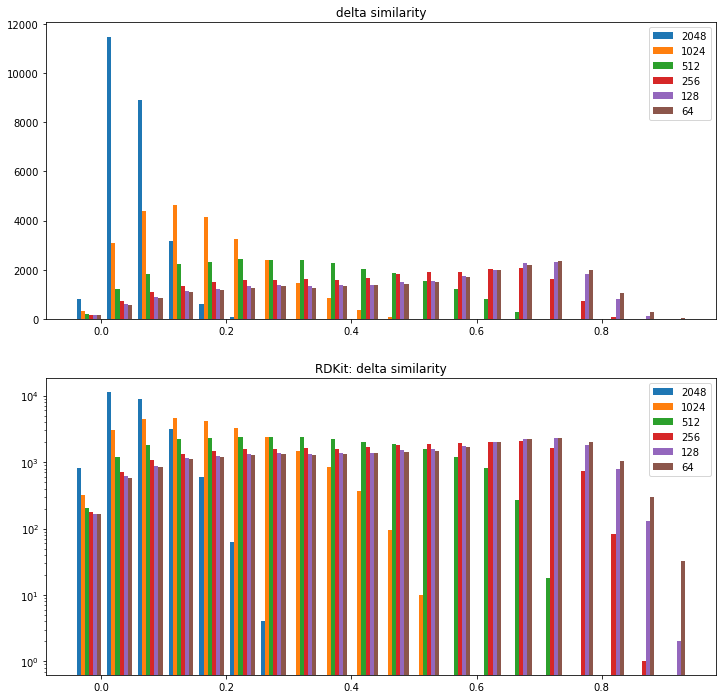

In [76]:
figsize(12,12)
bcounts = (2048,1024,512,256,128,64)

diffs = []
for bcount in bcounts:
    diffs.append(np.array(rdksims[bcount])-np.array(rdksims[4096]))
subplot(2,1,1)
hist(diffs,label=[str(x) for x in bcounts],bins=20);
legend();
title('delta similarity');
subplot(2,1,2)
hist(diffs,label=[str(x) for x in bcounts],bins=20,log=True);
legend();
title('RDKit: delta similarity');

The Spearman coefficients here show how quickly things degrade:

In [82]:
from scipy import stats
bcounts = (2048,1024,512,256,128,64)
for bcount in bcounts:
    r,p = stats.spearmanr(rdksims[bcount],rdksims[4096])
    print(f"{bcount} bits: r={r:.3f} p={p:.3g}")

2048 bits: r=0.986 p=0
1024 bits: r=0.911 p=0
512 bits: r=0.735 p=0
256 bits: r=0.506 p=0
128 bits: r=0.287 p=0
64 bits: r=0.103 p=1.39e-59


Clearly the RDKit fingerprints generated with the default parameters are not the ideal candidates to be folded into super-short fingerprints.

# Impact on similarity searching

Let's move on to looking at the impact shorter fingerprints have on similarity searching, specifically the number of results retrieved for queries using different similarity cutoffs.

Our test database for this is the SDF from ChEMBL27. I downloaded this directly from the [ChEMBL website](ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/).

Read in that SDF and generate MFP2 fingerprints:

In [30]:
import pickle, time, gzip

gz = gzip.GzipFile('/home/glandrum/Downloads/chembl_27.sdf.gz')
suppl = Chem.ForwardSDMolSupplier(gz)

RDLogger.DisableLog("rdApp.warning")
t1=time.time()
data = []

for i,mol in enumerate(suppl):
    if not ((i+1)%50000):
        print(f"Processed {i+1} molecules in {(time.time()-t1):.1f} seconds")
    if mol is None or mol.GetNumAtoms()>70:
        continue
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,2,nBits=4096)
    smi = Chem.MolToSmiles(mol)
    data.append((mol.GetProp('chembl_id'),smi,fp))
t2=time.time()
print(f"Processed {len(data)} molecules in {(t2-t1):.1f} seconds")


Processed 50000 molecules in 15.7 seconds
Processed 100000 molecules in 30.9 seconds
Processed 150000 molecules in 45.8 seconds
Processed 200000 molecules in 61.8 seconds
Processed 250000 molecules in 79.1 seconds
Processed 300000 molecules in 95.5 seconds
Processed 350000 molecules in 113.1 seconds
Processed 400000 molecules in 132.1 seconds
Processed 450000 molecules in 150.2 seconds
Processed 500000 molecules in 167.8 seconds
Processed 550000 molecules in 185.2 seconds
Processed 600000 molecules in 203.7 seconds


RDKit ERROR: [08:36:27] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [08:36:27] ERROR: Could not sanitize molecule ending on line 44530308


Processed 650000 molecules in 222.4 seconds
Processed 700000 molecules in 243.6 seconds
Processed 750000 molecules in 259.4 seconds
Processed 800000 molecules in 273.9 seconds
Processed 850000 molecules in 288.2 seconds
Processed 900000 molecules in 302.9 seconds
Processed 950000 molecules in 317.4 seconds
Processed 1000000 molecules in 333.0 seconds
Processed 1050000 molecules in 349.7 seconds
Processed 1100000 molecules in 366.1 seconds
Processed 1150000 molecules in 384.8 seconds
Processed 1200000 molecules in 401.7 seconds
Processed 1250000 molecules in 419.5 seconds
Processed 1300000 molecules in 438.1 seconds
Processed 1350000 molecules in 458.1 seconds
Processed 1400000 molecules in 475.6 seconds
Processed 1450000 molecules in 492.3 seconds
Processed 1500000 molecules in 508.3 seconds
Processed 1550000 molecules in 522.2 seconds
Processed 1600000 molecules in 538.5 seconds
Processed 1650000 molecules in 556.1 seconds
Processed 1700000 molecules in 574.4 seconds
Processed 1750000

Save those to disk so that we don't have to do that work again

In [31]:
pickle.dump(data,open('../data/chembl27_fps.pkl','wb+'))

In [11]:
data = pickle.load(open('../data/chembl27_fps.pkl','rb'))

Our queries are the set of "very active" compounds (compounds with subnanomolar measured Ki values) I [previously collected](https://rdkit.blogspot.com/2020/05/binary-molecules-and-cartridge.html) from ChEMBL26.

In [18]:
gz = gzip.GzipFile('../data/chembl26_very_active.sdf.gz')
suppl = Chem.ForwardSDMolSupplier(gz)
t1=time.time()
queries = []
for i,mol in enumerate(suppl):
    if not ((i+1)%50000):
        print(f"Processed {i+1} molecules in {(time.time()-t1):.1f} seconds")
    if mol is None or mol.GetNumAtoms()>70:
        continue
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,2,nBits=4096)
    smi = Chem.MolToSmiles(mol)
    queries.append((mol.GetProp('compound_chembl_id'),smi,fp))
t2=time.time()
print(f"Processed {len(queries)} molecules in {(t2-t1):.1f} seconds")


Processed 34348 molecules in 14.5 seconds


Now collect the data. We'll use 1000 randomly selected queries against the first million pubchem compounds.

We try a variety of different fingerprint sizes along with different similarity thresholds. For each threshold/size combination we keep track of the number of neighbors found for each query as well as the number of missing neighbors (neighbors found at that threshold with a 4096 bit fingerprint that were not found with the folded fingerprint).

In [19]:
import random
random.seed(0xf00d)
random.shuffle(queries)

In [25]:
dsize = 1000000
nQueries = 1000
from collections import defaultdict
def fold_fp(fp,sz):
    return DataStructs.FoldFingerprint(fp,fp.GetNumBits()//sz)
    
thresholds = [0.5,0.6,0.7,0.8,0.9]
sizes = [64,128,256,512,1024,2048]
results = defaultdict(lambda:defaultdict(list))
missed = defaultdict(lambda:defaultdict(list))
dbfps = [x[-1] for x in data[:dsize]]
for sz in sizes:
    print(f'Doing fp len {sz}')
    tfps = []
    print('\t folding')
    for cid,smi,fp in data[:dsize]:
        tfps.append(fold_fp(fp,sz))
    print('\t running queries')
    for qcid,qsmi,qfp in queries[:nQueries]:
        nqfp = fold_fp(qfp,sz)
        sims = DataStructs.BulkTanimotoSimilarity(nqfp,tfps)
        osims = DataStructs.BulkTanimotoSimilarity(qfp,dbfps)
        for thresh in thresholds:
            oindices = set(i for (i,x) in enumerate(osims) if x>=thresh)
            if sz==sizes[0]:
                results[4096][thresh].append(len(oindices))

            indices = set(i for (i,x) in enumerate(sims) if x>=thresh)
            
            cnt = len(indices)
            results[sz][thresh].append(cnt)
            missed[sz][thresh].append(len(oindices.difference(indices)))


Doing fp len 64
	 folding
	 running queries
Doing fp len 128
	 folding
	 running queries
Doing fp len 256
	 folding
	 running queries
Doing fp len 512
	 folding
	 running queries
Doing fp len 1024
	 folding
	 running queries
Doing fp len 2048
	 folding
	 running queries


that took a while to run, so save the results

In [26]:
dres = {}
for k in results:
    dres[k] = dict(results[k])
dmissed = {}
for k in missed:
    dmissed[k] = dict(missed[k])

pickle.dump((dres,dmissed),open('../data/size_and_neighbors_results.mfp2.pkl','wb+'))

In [2]:
results,missed = pickle.load(open('../data/size_and_neighbors_results.mfp2.pkl','rb'))

## Comparing the the number of neighbors retrieved

To get a sense of what the data look like, pick a couple of threshold values and do a direct comparison of the number of neighbors found at the other bit counts with the number found at 4096 bits.

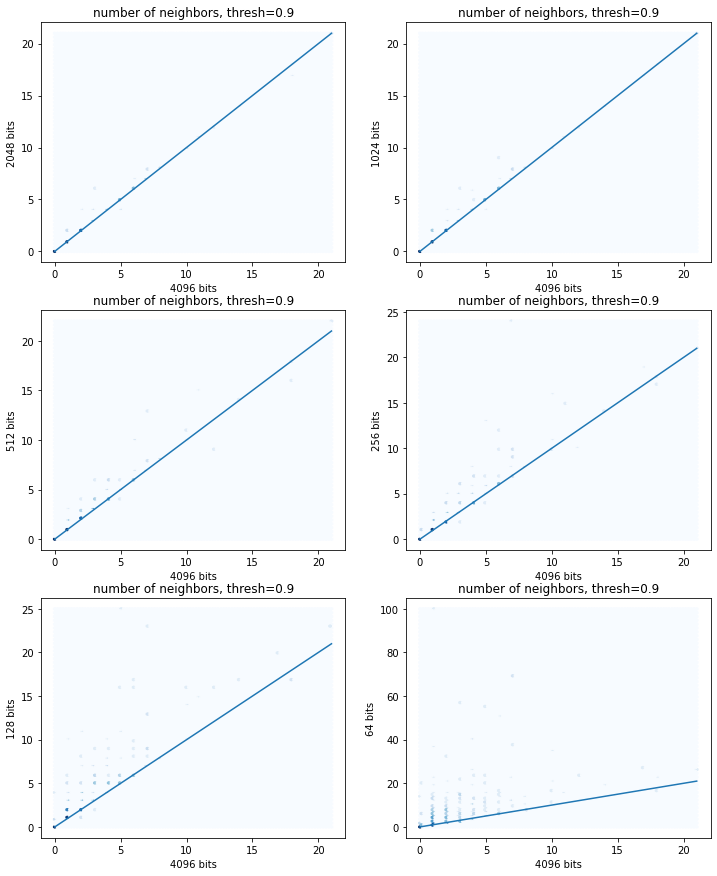

In [58]:
thresh = 0.9
bcounts = (2048,1024,512,256,128,64)

figsize(12,15)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    mv = max(results[xv][thresh])
    hexbin(results[xv][thresh],results[yv][thresh],bins='log',cmap='Blues')
    plot([0,mv],[0,mv]);
    xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:0.1f}');

Do the same thing with a threshold of 0.6

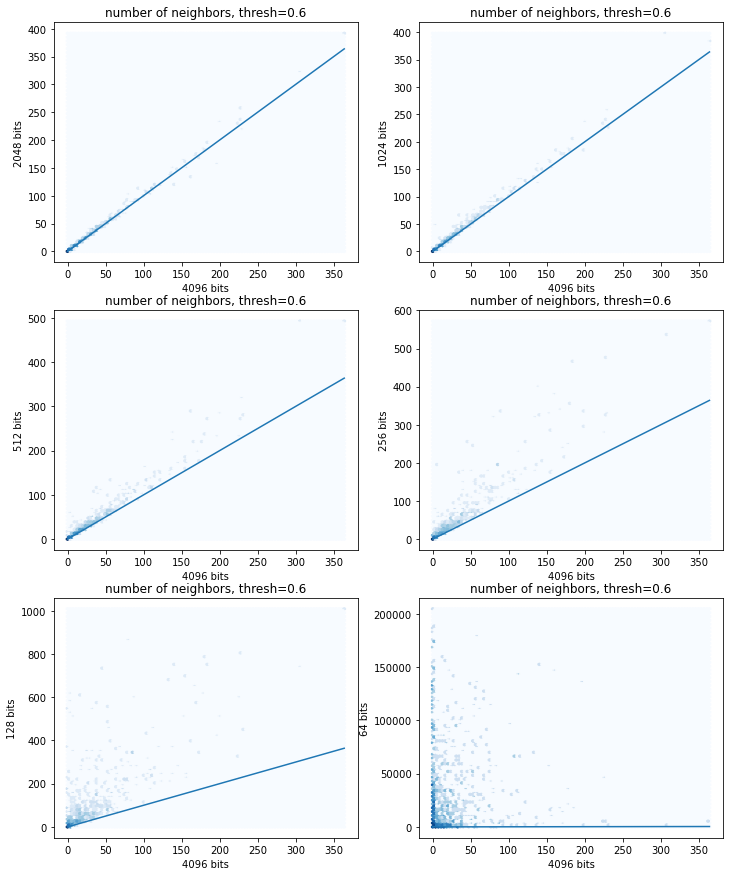

In [59]:
thresh = 0.6
bcounts = (2048,1024,512,256,128,64)

figsize(12,15)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    mv = max(results[xv][thresh])
    hexbin(results[xv][thresh],results[yv][thresh],bins='log',cmap='Blues')
    plot([0,mv],[0,mv]);
    xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:0.1f}');

We can see here that the more folded fingerprints tend to yield more neighors at a given threshold. This makese sense given what we saw above, which is that similarity values tend to be higher as fingerprints are folded.

It's also clear, though not super surprising, that the 64 bit fingerprint isn't going to be useful with low similarity thresholds: we just get way too many extra hits.

## How many hits do we miss?

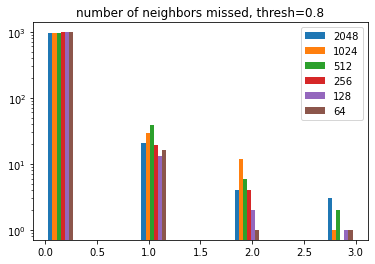

In [28]:
thresh = 0.8
bcounts = (2048,1024,512,256,128,64)
hist([missed[x][0.8] for x in bcounts],log='true', label=[str(x) for x in bcounts]);
legend();
title(f'number of neighbors missed, thresh={thresh:.1f}');

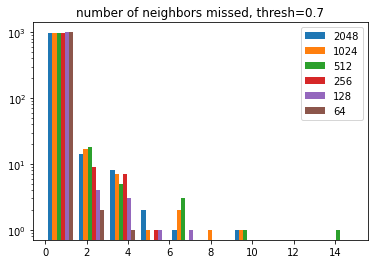

In [29]:
thresh = 0.7
bcounts = (2048,1024,512,256,128,64)
hist([missed[x][thresh] for x in bcounts],log='true', label=[str(x) for x in bcounts]);
legend();
title(f'number of neighbors missed, thresh={thresh:.1f}');

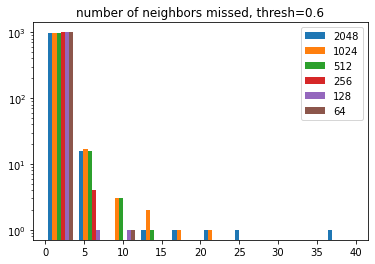

In [30]:
figsize(6,4)

thresh = 0.6
bcounts = (2048,1024,512,256,128,64)
hist([missed[x][thresh] for x in bcounts],log='true', label=[str(x) for x in bcounts]);
legend();
title(f'number of neighbors missed, thresh={thresh:.1f}');

Look at result counts where hits were missed

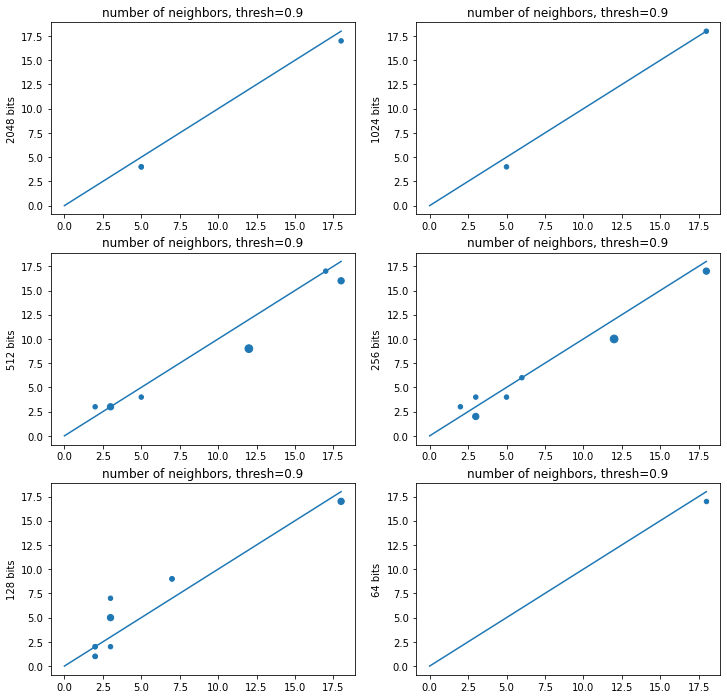

In [31]:
thresh = 0.9

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    tresx = [x for i,x in enumerate(results[xv][thresh]) if missed[yv][thresh][i]]
    tresy = [x for i,x in enumerate(results[yv][thresh]) if missed[yv][thresh][i]]
    tresr = [20*x for i,x in enumerate(missed[yv][thresh]) if x]
    mv = max(tresx)
    scatter(tresx,tresy,tresr)
    plot([0,mv],[0,mv]);
    #xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:.1f}');

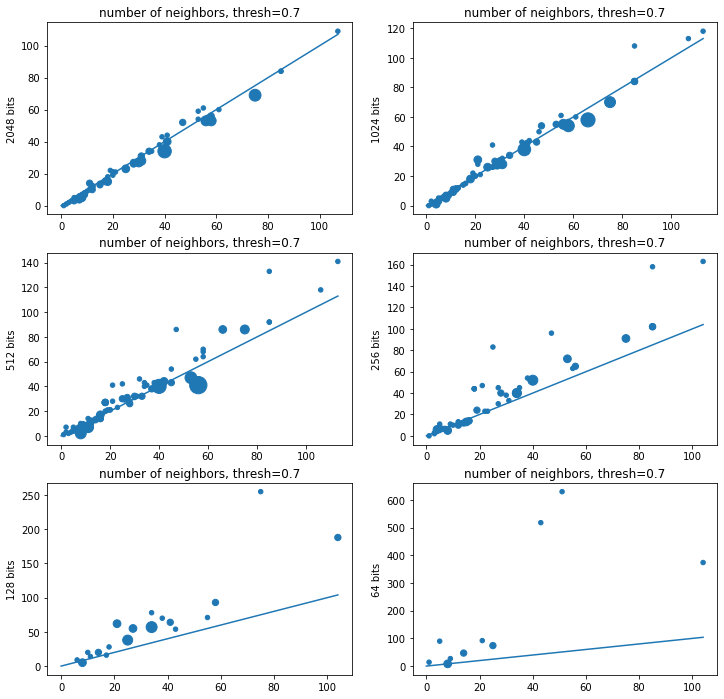

In [32]:
thresh = 0.7

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    tresx = [x for i,x in enumerate(results[xv][thresh]) if missed[yv][thresh][i]]
    tresy = [x for i,x in enumerate(results[yv][thresh]) if missed[yv][thresh][i]]
    tresr = [20*x for i,x in enumerate(missed[yv][thresh]) if x]
    mv = max(tresx)
    scatter(tresx,tresy,tresr)
    plot([0,mv],[0,mv]);
    #xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:.1f}');

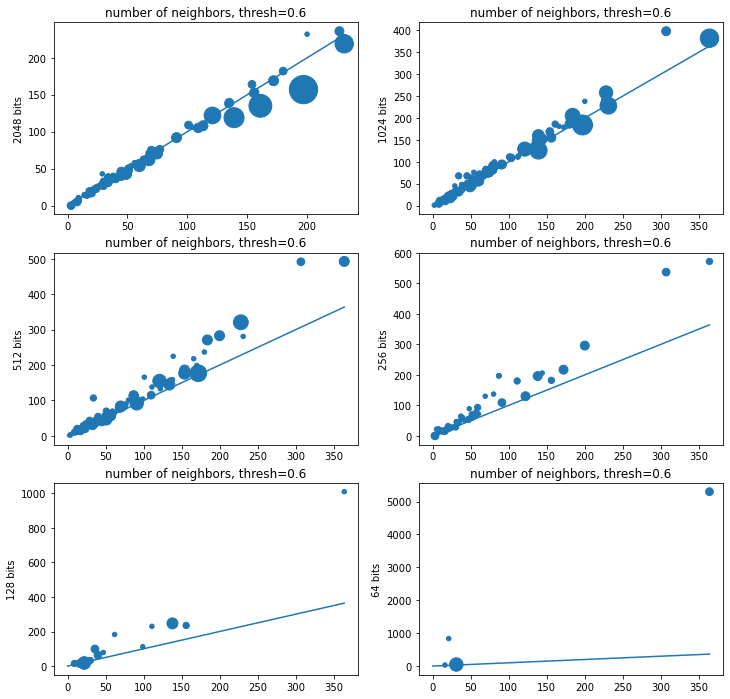

In [39]:
thresh = 0.6

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    tresx = [x for i,x in enumerate(results[xv][thresh]) if missed[yv][thresh][i]]
    tresy = [x for i,x in enumerate(results[yv][thresh]) if missed[yv][thresh][i]]
    tresr = [20*x for i,x in enumerate(missed[yv][thresh]) if x]
    mv = max(tresx)
    sc = scatter(tresx,tresy,tresr)
    plot([0,mv],[0,mv]);
    #xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:.1f}');

## Efficiency, look at the number of extra hits

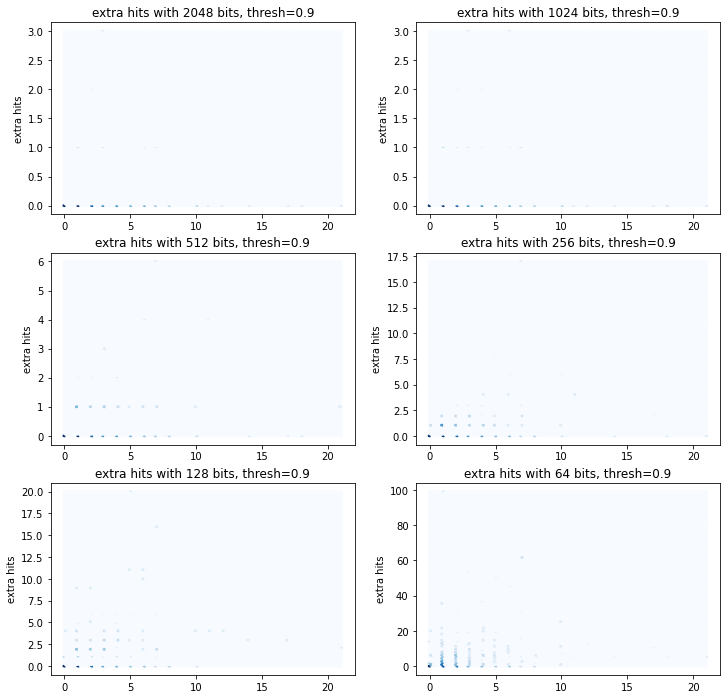

In [49]:
thresh = 0.9

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    delt = [x-results[xv][thresh][i] for i,x in enumerate(results[yv][thresh])]
    tresx = [x for i,x in enumerate(results[xv][thresh]) if delt[i]>=0]
    tresy = [x for i,x in enumerate(delt) if x>=0]
    mv = max(tresx)
    hexbin(tresx,tresy,bins='log',cmap='Blues')
    ylabel(f'extra hits');
    title(f'extra hits with {yv} bits, thresh={thresh:.1f}');

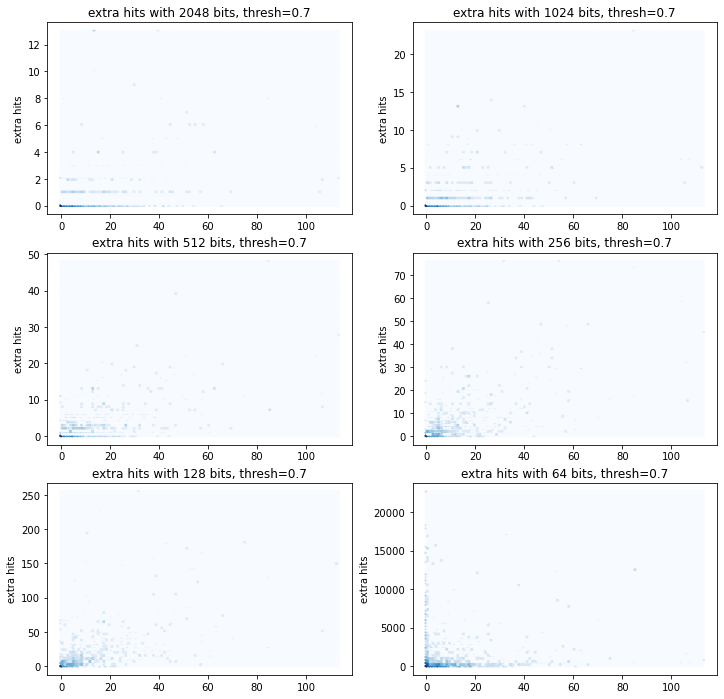

In [48]:
thresh = 0.7

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    delt = [x-results[xv][thresh][i] for i,x in enumerate(results[yv][thresh])]
    tresx = [x for i,x in enumerate(results[xv][thresh]) if delt[i]>=0]
    tresy = [x for i,x in enumerate(delt) if x>=0]
    mv = max(tresx)
    hexbin(tresx,tresy,bins='log',cmap='Blues')
    ylabel(f'extra hits');
    title(f'extra hits with {yv} bits, thresh={thresh:.1f}');

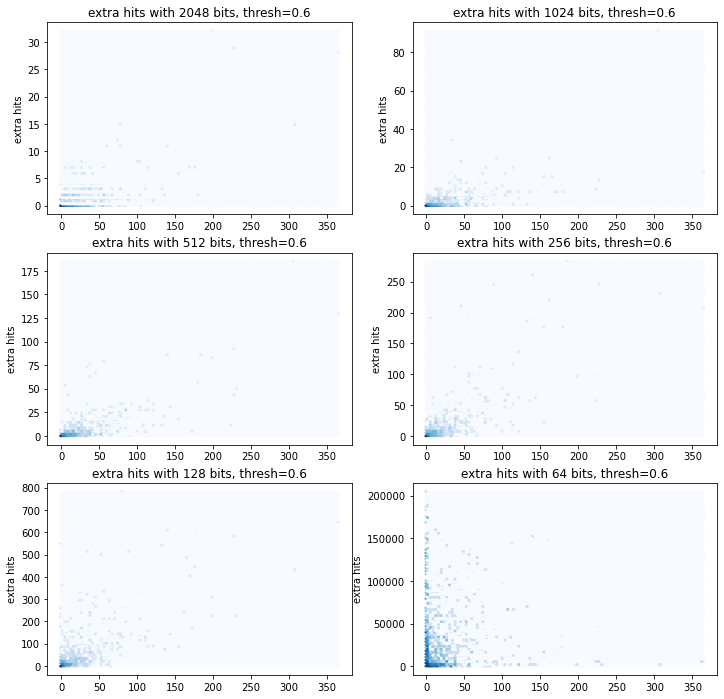

In [47]:
thresh = 0.6

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    delt = [x-results[xv][thresh][i] for i,x in enumerate(results[yv][thresh])]
    tresx = [x for i,x in enumerate(results[xv][thresh]) if delt[i]>=0]
    tresy = [x for i,x in enumerate(delt) if x>=0]
    mv = max(tresx)
    hexbin(tresx,tresy,bins='log',cmap='Blues')
    ylabel(f'extra hits');
    title(f'extra hits with {yv} bits, thresh={thresh:.1f}');

This makes it even more obvious that the 64bit fingerprints are just too short. 128 bits seems to be a good balance.

# Performance impact of FP size

## In PostgreSQL

Here we're using slightly different datasets: the database is the full ChEMBL26 (instead of the first million molecules in ChEMBL27) and the queries are 1000 molecules randomly selected from ChEMBL26.

Start by setting up the tables with the different fingerprint sizes:
```
chembl_26=# set rdkit.morgan_fp_size=2048;
SET
Time: 0.335 ms
chembl_26=# select molregno,morganbv_fp(m) as mfp2 into rdk.fps2048 from rdk.mols;
SELECT 1940732
Time: 115226.927 ms (01:55.227)
chembl_26=# set rdkit.morgan_fp_size=128;
SET
Time: 0.140 ms
chembl_26=# select molregno,morganbv_fp(m) as mfp2 into rdk.fps128 from rdk.mols;
SELECT 1940732
Time: 105524.382 ms (01:45.524)
chembl_26=# \dt+ rdk.fps2048;
                     List of relations
 Schema |  Name   | Type  |  Owner   |  Size  | Description 
--------+---------+-------+----------+--------+-------------
 rdk    | fps2048 | table | glandrum | 562 MB | 
(1 row)

chembl_26=# \dt+ rdk.fps128;
                     List of relations
 Schema |  Name  | Type  |  Owner   |  Size  | Description 
--------+--------+-------+----------+--------+-------------
 rdk    | fps128 | table | glandrum | 112 MB | 
(1 row)

chembl_26=# create index fps128_mfp2_idx on rdk.fps128 using gist(mfp2);
CREATE INDEX
Time: 25325.528 ms (00:25.326)
chembl_26=# set rdkit.morgan_fp_size=2048;
SET
Time: 0.154 ms
chembl_26=# create index fps2048_mfp2_idx on rdk.fps2048 using gist(mfp2);
CREATE INDEX
Time: 195260.817 ms (03:15.261)
```

Now create the tables with 1000 randomly chosen queries:

```
chembl_26=# select * into table rdk.tmpqs2048 from rdk.fps2048 tablesample system(0.1) limit 1000;
SELECT 1000
Time: 14.196 ms
chembl_26=# select fps.* into table rdk.tmpqs128 from rdk.fps128 fps join rdk.tmpqs2048 using (molregno);
SELECT 1000
Time: 134.327 ms
```

Run the 2048 bit and 128 bit queries:
```
chembl_26=# create or replace function get_count2048(qfp2 bfp) returns table(cnt bigint) as
$$
select count(*) from rdk.fps2048 tbl where tbl.mfp2%qfp2;
$$ language sql stable;
CREATE FUNCTION
Time: 67.197 ms
chembl_26=# set rdkit.tanimoto_threshold=0.9;
SET
Time: 0.132 ms
chembl_26=# select min(cnt),max(cnt),avg(cnt) from (select get_count2048(mfp2) cnt from rdk.tmpqs2048) tmp;
 min | max |        avg         
-----+-----+--------------------
   1 |  49 | 1.5690000000000000
(1 row)

Time: 33572.026 ms (00:33.572)
chembl_26=# set rdkit.tanimoto_threshold=0.7;
SET
Time: 0.419 ms
chembl_26=# select min(cnt),max(cnt),avg(cnt) from (select get_count2048(mfp2) cnt from rdk.tmpqs2048) tmp;
 min | max |        avg         
-----+-----+--------------------
   1 | 737 | 9.3190000000000000
(1 row)

Time: 99049.256 ms (01:39.049)
chembl_26=# set rdkit.tanimoto_threshold=0.6;
SET
Time: 0.393 ms
chembl_26=# select min(cnt),max(cnt),avg(cnt) from (select get_count2048(mfp2) cnt from rdk.tmpqs2048) tmp;
 min | max  |         avg         
-----+------+---------------------
   1 | 1274 | 28.0480000000000000
(1 row)

Time: 182964.348 ms (03:02.964)
chembl_26=# create or replace function get_count128(qfp2 bfp) returns table(cnt bigint) as
$$
select count(*) from rdk.fps128 tbl where tbl.mfp2%qfp2;
$$ language sql stable;
CREATE FUNCTION
Time: 67.593 ms
chembl_26=# set rdkit.tanimoto_threshold=0.9;
SET
Time: 0.389 ms
chembl_26=# select min(cnt),max(cnt),avg(cnt) from (select get_count128(mfp2) cnt from rdk.tmpqs128) tmp;
 min | max |        avg         
-----+-----+--------------------
   1 | 255 | 2.1610000000000000
(1 row)

Time: 44760.287 ms (00:44.760)
chembl_26=# set rdkit.tanimoto_threshold=0.7;
SET
Time: 0.145 ms
chembl_26=# select min(cnt),max(cnt),avg(cnt) from (select get_count128(mfp2) cnt from rdk.tmpqs128) tmp;
 min | max  |         avg         
-----+------+---------------------
   1 | 2046 | 31.8120000000000000
(1 row)

Time: 107402.701 ms (01:47.403)

chembl_26=# set rdkit.tanimoto_threshold=0.6;
SET
Time: 0.112 ms
chembl_26=# select min(cnt),max(cnt),avg(cnt) from (select get_count128(mfp2) cnt from rdk.tmpqs128) tmp;
 min | max  |         avg          
-----+------+----------------------
   1 | 8956 | 170.5990000000000000
(1 row)

Time: 126819.459 ms (02:06.819)
```


Finally check what happens if we turn off the index and just do a sequential scan:
```
chembl_26=# set enable_bitmapscan=off;
SET
Time: 0.353 ms
chembl_26=# set enable_indexscan=off;
SET
Time: 0.351 ms
chembl_26=# select min(cnt),max(cnt),avg(cnt) from (select get_count128(mfp2) cnt from rdk.tmpqs128) tmp;
 min |  max  |         avg         
-----+-------+---------------------
   1 | 12201 | 84.1850000000000000
(1 row)

Time: 1120514.600 ms (18:40.515)
```

Ouch, don't want to do that!

### Summarize that

Here's a summary of the runtime (in seconds) to run the 1000 queries for different thresholds and number of bits:

| Threshold | 2048 bits | 128 bits |
| --------- | --------- | -------- |
| 0.9       |  33.6     |  44.8    |
| 0.7       |  99.0     |  107.4   |
| 0.6       |  183.0    |  126.8   |

What's interesting here is that the 128 bit fingerprint only becomes faster than the 2048 bit fingerprint when the similarity threshold is low. I haven't dug into this (yet?), but I guess the less computationally intensive searches with the shorter fingerprints are being outweighed by less-accurate index results,

## Using FPSim2

[FPSim2](https://github.com/chembl/FPSim2) is an interesting project from Eloy and the ChEMBL team to allow fast similarity searching with either a CPU or a GPU. I haven't really tried it out before, so I figured I would do it as part of this post.

After installing FPSim2 I created db files for both 2048 and 128 bit Morgan2 fingerprints for the ChEMBL27 compounds by following the instructions in the [FPSim2 docs](https://chembl.github.io/FPSim2/source/user_guide/create_fp_db.html).

Now let's do some searches:

In [83]:
import time
from FPSim2 import FPSim2Engine
import numpy as np

In [84]:
queries = [x.split() for x in open('../data/chembl26_1000simqueries.txt').readlines()]

### On-disk queries

Start by doing on-disk queries. We wouldn't normally do this unless the dataset was huge, but it's worth establishing a baseline:

In [69]:
for thresh in (0.9,0.8,0.7,0.6):
    cnts = []
    t1 = time.time()
    fpe = FPSim2Engine('../data/chembl27_mfp2.2048.h5',in_memory_fps=False)
    for mrn,smi in queries:
        res = fpe.on_disk_similarity(smi,thresh,n_workers=1)
        cnts.append(len(res))
    t2 = time.time()
    print(f"threshold={thresh} time={t2-t1:.2f} min={min(cnts)} max={max(cnts)} avg={np.average(cnts)}")

threshold=0.9 time=85.29 min=1 max=49 avg=1.57
threshold=0.8 time=163.08 min=1 max=368 avg=3.336
threshold=0.7 time=231.87 min=1 max=737 avg=9.332
threshold=0.6 time=284.70 min=1 max=1274 avg=28.08


In [4]:
for thresh in (0.9,0.8,0.7,0.6):
    cnts128 = []
    t1 = time.time()
    fpe = FPSim2Engine('../data/chembl27_mfp2.128.h5',in_memory_fps=False)
    for mrn,smi in queries:
        res = fpe.on_disk_similarity(smi,thresh,n_workers=1)
        cnts128.append(len(res))
    t2 = time.time()
    print(f"threshold={thresh} time={t2-t1:.2f} min={min(cnts128)} max={max(cnts128)} avg={np.average(cnts128)}")

threshold=0.9 time=8.83 min=1 max=255 avg=2.162
threshold=0.8 time=15.07 min=1 max=931 avg=8.353
threshold=0.7 time=19.90 min=1 max=2046 avg=31.849
threshold=0.6 time=23.61 min=1 max=8963 avg=170.709


The 128 bit times here aren't that terrible, but the 2048 bit queries are slow (slower than PostgreSQL is, for example).

### In-memory queries

This time load the fingerprints into memory and then search them. I imagine that this is a more normal mode for working with FPSim2. The results are, of course, be significantly faster:

In [6]:
for thresh in (0.9,0.8,0.7,0.6):
    cnts = []
    t1 = time.time()
    fpe = FPSim2Engine('../data/chembl27_mfp2.2048.h5')
    for mrn,smi in queries:
        res = fpe.similarity(smi,thresh)
        cnts.append(len(res))
    t2 = time.time()
    print(f"threshold={thresh} time={t2-t1:.2f} min={min(cnts)} max={max(cnts)} avg={np.average(cnts)}")

threshold=0.9 time=12.12 min=1 max=49 avg=1.57
threshold=0.8 time=22.32 min=1 max=368 avg=3.336
threshold=0.7 time=31.22 min=1 max=737 avg=9.332
threshold=0.6 time=38.45 min=1 max=1274 avg=28.08


In [7]:
for thresh in (0.9,0.8,0.7,0.6):
    cnts = []
    t1 = time.time()
    fpe = FPSim2Engine('../data/chembl27_mfp2.128.h5')
    for mrn,smi in queries:
        res = fpe.similarity(smi,thresh)
        cnts.append(len(res))
    t2 = time.time()
    print(f"threshold={thresh} time={t2-t1:.2f} min={min(cnts)} max={max(cnts)} avg={np.average(cnts)}")

threshold=0.9 time=2.51 min=1 max=255 avg=2.162
threshold=0.8 time=4.21 min=1 max=931 avg=8.353
threshold=0.7 time=5.68 min=1 max=2046 avg=31.849
threshold=0.6 time=7.02 min=1 max=8963 avg=170.709


The 128 bit fingerprints are still quite a bit faster than then 2048 bit fingerprints. We're really seeing the benefit of not having to do as much work when calculating similarities here.

### Multi-threaded queries

FPSim2 lets us do multi-threaded queries when working with fingerprints in-memory. Try that out:

In [8]:
for thresh in (0.9,0.8,0.7,0.6):
    cnts = []
    t1 = time.time()
    fpe = FPSim2Engine('../data/chembl27_mfp2.2048.h5')
    for mrn,smi in queries:
        res = fpe.similarity(smi,thresh, n_workers=4)
        cnts.append(len(res))
    t2 = time.time()
    print(f"threshold={thresh} time={t2-t1:.2f} min={min(cnts)} max={max(cnts)} avg={np.average(cnts)}")

threshold=0.9 time=6.50 min=1 max=49 avg=1.57
threshold=0.8 time=10.64 min=1 max=368 avg=3.336
threshold=0.7 time=14.18 min=1 max=737 avg=9.332
threshold=0.6 time=17.17 min=1 max=1274 avg=28.08


In [10]:
for thresh in (0.9,0.8,0.7,0.6):
    cnts = []
    t1 = time.time()
    fpe = FPSim2Engine('../data/chembl27_mfp2.2048.h5')
    for mrn,smi in queries:
        res = fpe.similarity(smi,thresh, n_workers=2)
        cnts.append(len(res))
    t2 = time.time()
    print(f"threshold={thresh} time={t2-t1:.2f} min={min(cnts)} max={max(cnts)} avg={np.average(cnts)}")

threshold=0.9 time=8.15 min=1 max=49 avg=1.57
threshold=0.8 time=14.03 min=1 max=368 avg=3.336
threshold=0.7 time=18.73 min=1 max=737 avg=9.332
threshold=0.6 time=22.91 min=1 max=1274 avg=28.08


In [9]:
for thresh in (0.9,0.8,0.7,0.6):
    cnts = []
    t1 = time.time()
    fpe = FPSim2Engine('../data/chembl27_mfp2.128.h5')
    for mrn,smi in queries:
        res = fpe.similarity(smi,thresh,n_workers=4)
        cnts.append(len(res))
    t2 = time.time()
    print(f"threshold={thresh} time={t2-t1:.2f} min={min(cnts)} max={max(cnts)} avg={np.average(cnts)}")

threshold=0.9 time=2.08 min=1 max=255 avg=2.162
threshold=0.8 time=2.54 min=1 max=931 avg=8.353
threshold=0.7 time=3.10 min=1 max=2046 avg=31.849
threshold=0.6 time=3.40 min=1 max=8963 avg=170.709


In [11]:
for thresh in (0.9,0.8,0.7,0.6):
    cnts = []
    t1 = time.time()
    fpe = FPSim2Engine('../data/chembl27_mfp2.128.h5')
    for mrn,smi in queries:
        res = fpe.similarity(smi,thresh,n_workers=2)
        cnts.append(len(res))
    t2 = time.time()
    print(f"threshold={thresh} time={t2-t1:.2f} min={min(cnts)} max={max(cnts)} avg={np.average(cnts)}")

threshold=0.9 time=2.18 min=1 max=255 avg=2.162
threshold=0.8 time=4.01 min=1 max=931 avg=8.353
threshold=0.7 time=4.54 min=1 max=2046 avg=31.849
threshold=0.6 time=4.90 min=1 max=8963 avg=170.709


Summarize the in-memory results

| Threshold | Num threads | 2048 bits | 128 bits |
| --------- | ----------- | --------- | -------- |
| 0.9       | 1           | 12.1      |  2.5     |
| 0.9       | 2           | 8.2       |  2.2     |
| 0.7       | 1           | 31.2      |  5.7     |
| 0.7       | 2           | 18.7      |  4.5     |
| 0.6       | 1           | 38.4      |  7.0     |
| 0.6       | 2           | 22.9      |  4.9     |
